In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [2]:
Xtr = pd.read_csv('Xtr_final.csv')
Xte = pd.read_csv('Xte_final.csv')
Ytr = pd.read_csv('Ytr.csv')

C:\Users\Tyler\AppData\Local\Temp\ipykernel_1988\4056427700.py:2: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  Xte = pd.read_csv('Xte_temp2.csv')


In [3]:
# Creating a new feature named Ratio
merged_data = Xtr.merge(Ytr, on='ID')
merged_data['Ratio'] = merged_data['Sale_Amount'] / merged_data['Assessed_Value']
merged_data['Ratio'] = merged_data['Ratio'].replace(0, np.nan)
result = merged_data.groupby(['List_Year', 'Town'])[['Ratio']].mean().reset_index()
result['Ratio'] = result['Ratio'].replace([np.inf, -np.inf], np.nan)
label_encoder = LabelEncoder()
result['Town'] = label_encoder.fit_transform(result['Town'])
data = result[['List_Year', 'Town', 'Ratio']]

# Imputation missing Sales_Ratio by using KNNImputer
# Reason: When creating Ratio, there should be missing values since we have missing Assessed_Value.
imputer = KNNImputer(n_neighbors=30)
imputed_data = imputer.fit_transform(data)
result['Sales_Ratio'] = imputed_data[:, 2]
Town = merged_data.groupby(['List_Year', 'Town'])[['Ratio']].mean().reset_index()
result['Town'] = Town['Town']
Xtr = Xtr.merge(result[['List_Year', 'Town', 'Ratio']], on=['List_Year', 'Town'], how='left')
mean_sales_ratio = Xtr.groupby(['List_Year', 'Town'])[['Ratio']].mean().reset_index()
Xte = Xte.merge(mean_sales_ratio, on=['List_Year', 'Town'], how='left')

In [4]:
# Filling up Ratio if there are still missing
mean_fillna = Xtr.groupby(['Town'])['Ratio'].transform('median')
Xtr['Ratio'].fillna(mean_fillna, inplace=True)

mean_fillna = Xte.groupby(['Town'])['Ratio'].transform('median')
Xte['Ratio'].fillna(mean_fillna, inplace=True)

In [5]:
Xtr4 = Xtr[["List_Year", "Assessed_Value", "Town", 'Ratio']]
Xte4 = Xte[["List_Year", "Assessed_Value", "Town", 'Ratio']]

# Calculate feature1Btr
towns = Xtr4["Town"].unique()
feature1Btr = np.empty(len(Xtr4))
for town in towns:
    mask = Xtr4["Town"] == town
    mu = Ytr.loc[mask, "Sale_Amount"].mean()
    feature1Btr[mask] = mu

# Calculate feature1Bte
feature1Bte = np.zeros(len(Xte4))
for town in towns:
    mask = Xtr4["Town"] == town
    mu = Ytr.loc[mask, "Sale_Amount"].mean()
    mask = Xte4["Town"] == town
    feature1Bte[mask] = mu

# Add F1B feature
Xtr4["F1B"] = feature1Btr
Xte4["F1B"] = feature1Bte

# Drop the "Town" column
Xtr4.drop("Town", axis=1, inplace=True)
Xte4.drop("Town", axis=1, inplace=True)

C:\Users\Tyler\AppData\Local\Temp\ipykernel_1988\3278282528.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtr4["F1B"] = feature1Btr
C:\Users\Tyler\AppData\Local\Temp\ipykernel_1988\3278282528.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xte4["F1B"] = feature1Bte
C:\Users\Tyler\AppData\Local\Temp\ipykernel_1988\3278282528.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [6]:
X_train, X_valid, Y_train, Y_valid = train_test_split(Xtr4, Ytr["Sale_Amount"], test_size=0.2, random_state=42)
model = XGBRegressor(learning_rate=0.1, colsample_bytree=0.8)

model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [11]:
Y_train_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
print("Training RMSE:", rmse_train)

Yte_pred = model.predict(Xte4)
pred3 = pd.DataFrame(index=Xte4.index)
pred3["Sale_Amount"] = Yte_pred

Training RMSE: 338432.7338774746
Test RMSE: 364137.3475643079


In [8]:
pred_final = pd.read_csv('pred0.csv')
pred_final["Sale_Amount"] = Yte_pred

In [9]:
pred_final.to_csv('pred_final.csv', index=False)

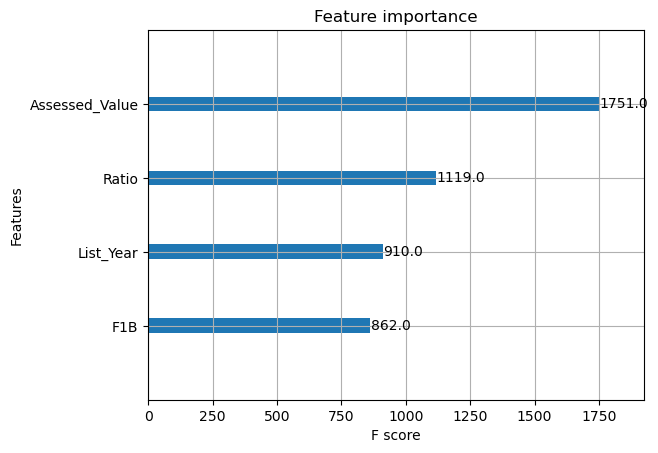

In [10]:
xgb.plot_importance(model, importance_type='weight')  # You can also use 'gain' or 'cover' as importance_type
plt.show()